<a href="https://colab.research.google.com/github/aulialigar/Capstone_SIB_Dicoding/blob/main/2_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/data.zip -d data/

Archive:  drive/MyDrive/data.zip
  inflating: data/test_data_classification.csv  
  inflating: data/train_data_classification.csv  
  inflating: data/data_forecasting_final.csv  


Menampilkan dataset

In [ ]:
df = pd.read_csv("data/data_forecasting_final.csv")
df

,tanggal,pm10,so2,co,o3,no2
0,2010-01-01,60.0,4.0,73.0,27.0,14.0
1,2010-01-02,32.0,2.0,16.0,33.0,9.0
2,2010-01-03,27.0,2.0,19.0,20.0,9.0
3,2010-01-04,22.0,2.0,16.0,15.0,6.0
4,2010-01-05,25.0,2.0,17.0,15.0,8.0
...,...,...,...,...,...,...
4225,2021-07-27,82.0,56.0,13.0,41.0,35.0
4226,2021-07-28,82.0,53.0,18.0,40.0,45.0
4227,2021-07-29,78.0,52.0,18.0,53.0,39.0
4228,2021-07-30,90.0,54.0,15.0,81.0,35.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230 entries, 0 to 4229
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tanggal  4230 non-null   object 
 1   pm10     4230 non-null   float64
 2   so2      4230 non-null   float64
 3   co       4230 non-null   float64
 4   o3       4230 non-null   float64
 5   no2      4230 non-null   float64
dtypes: float64(5), object(1)
memory usage: 198.4+ KB


In [ ]:
df.tanggal = pd.to_datetime(df.tanggal)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230 entries, 0 to 4229
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   tanggal  4230 non-null   datetime64[ns]
 1   pm10     4230 non-null   float64       
 2   so2      4230 non-null   float64       
 3   co       4230 non-null   float64       
 4   o3       4230 non-null   float64       
 5   no2      4230 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 198.4 KB


In [ ]:
df.describe()

,pm10,so2,co,o3,no2
count,4230.000000,4230.000000,4230.000000,4230.000000,4230.000000
mean,65.613841,27.801089,32.123599,93.409482,19.446529
std,18.922869,15.554703,13.044231,47.957399,13.216514
min,19.000000,2.000000,5.000000,9.000000,3.000000
25%,55.000000,17.000000,23.000000,60.000000,13.000000
50%,65.000000,26.000000,30.000000,84.000000,17.000000
75%,75.000000,33.000000,38.000000,116.000000,21.000000
max,178.000000,126.000000,134.000000,314.000000,148.000000


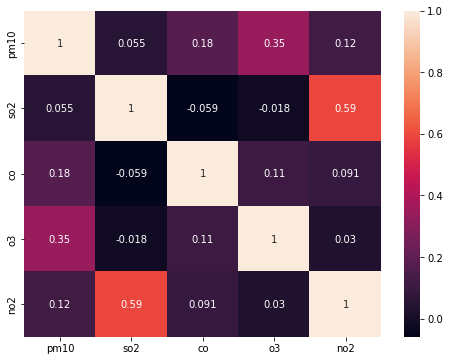

In [ ]:
plt.figure(figsize=(8,6))

sns.heatmap(df.corr(), annot=True)

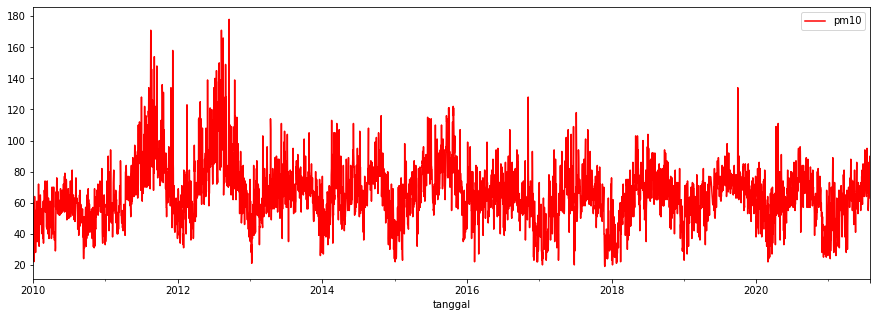

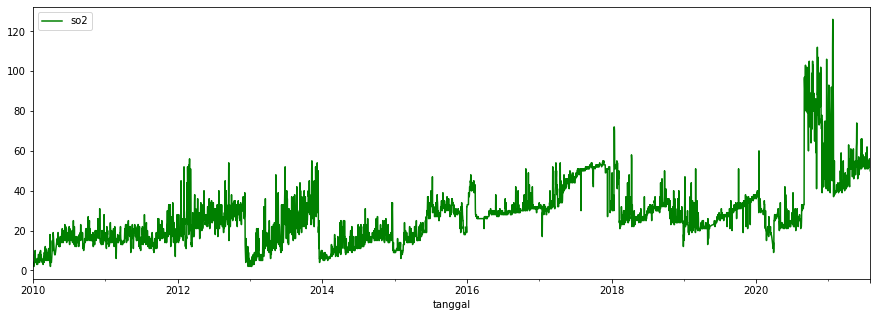

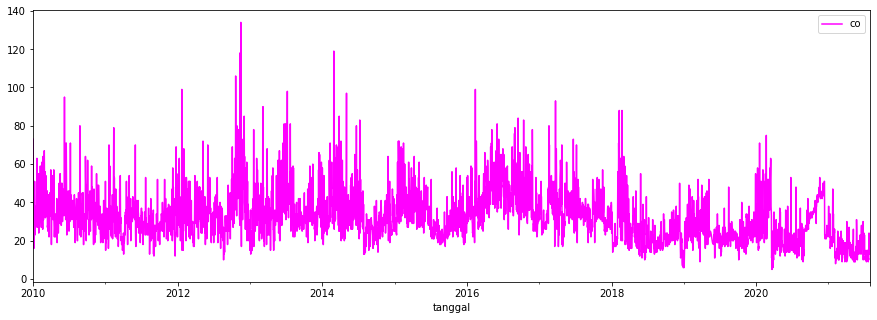

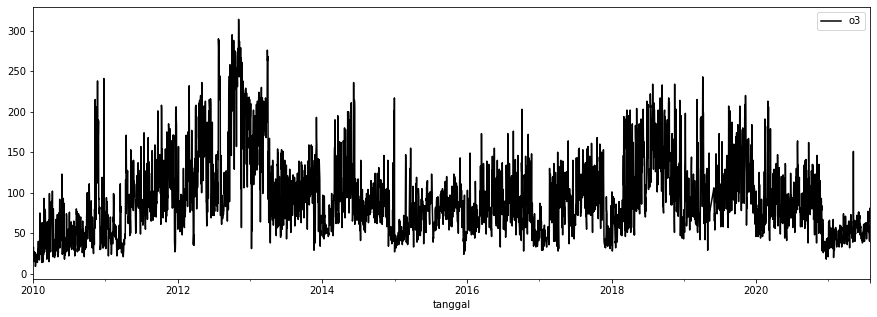

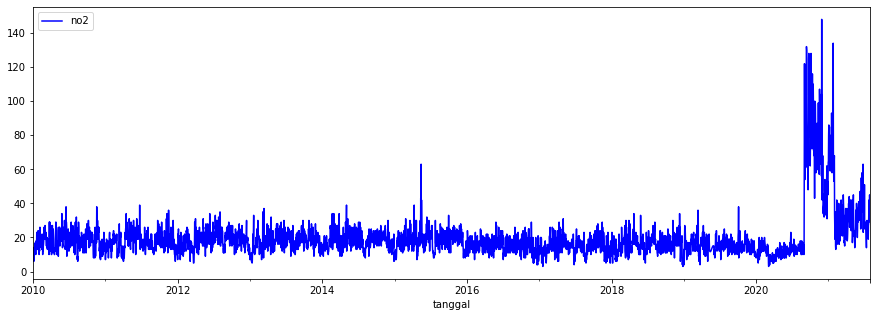

In [ ]:
df_resample = (df.set_index('tanggal')).resample('D').mean().reset_index()

df_resample.plot(x='tanggal', y='pm10', kind='line', color='red', figsize=(15,5))
df_resample.plot(x='tanggal', y='so2', kind='line', color='green', figsize=(15,5))
df_resample.plot(x='tanggal', y='co', kind='line', color='magenta', figsize=(15,5))
df_resample.plot(x='tanggal', y='o3', kind='line', color='black', figsize=(15,5))
df_resample.plot(x='tanggal', y='no2', kind='line', color='blue', figsize=(15,5))

In [ ]:
# Normalization
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

#Modelling

In [ ]:
window_size = 30
batch_size = 8
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, batch_size, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

##pm10

In [ ]:
pm10 = df['pm10'].values.reshape(-1, 1)
pm10 = min_max_scaler.fit_transform(pm10)
time = df.index.values + 1

In [ ]:
minMAE = (pm10.max() - pm10.min()) * 0.1
minMAE

0.1

In [ ]:
split_time = int(0.9 * len(pm10))
time_train = time[:split_time]
x_train = pm10[:split_time]
time_valid = time[split_time:]
x_valid = pm10[split_time:]

In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(3807, 1)


In [ ]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(val_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(423, 1)


In [ ]:
model_pm10 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_pm10.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model_pm10.fit(train_set, validation_data=(val_set), epochs=100)

Epoch 1/100
473/473 [==============================] - 7s 8ms/step - loss: 0.0252 - mse: 0.0503 - mae: 0.1875 - val_loss: 0.0075 - val_mse: 0.0151 - val_mae: 0.1068
Epoch 2/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0090 - mse: 0.0181 - mae: 0.0997 - val_loss: 0.0043 - val_mse: 0.0086 - val_mae: 0.0745
Epoch 3/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0068 - mse: 0.0136 - mae: 0.0855 - val_loss: 0.0041 - val_mse: 0.0082 - val_mae: 0.0702
Epoch 4/100
473/473 [==============================] - 4s 8ms/step - loss: 0.0065 - mse: 0.0129 - mae: 0.0838 - val_loss: 0.0042 - val_mse: 0.0084 - val_mae: 0.0700
Epoch 5/100
473/473 [==============================] - 4s 8ms/step - loss: 0.0064 - mse: 0.0127 - mae: 0.0835 - val_loss: 0.0042 - val_mse: 0.0085 - val_mae: 0.0700
Epoch 6/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0063 - mse: 0.0126 - mae: 0.0835 - val_loss: 0.0042 - val_mse: 0.0085 - val_mae: 0.0700
Epoch 7/10

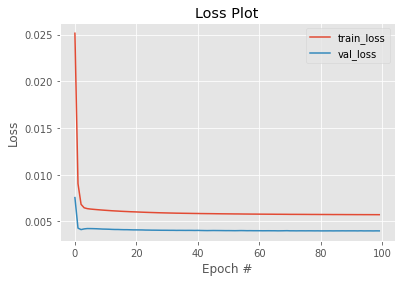

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

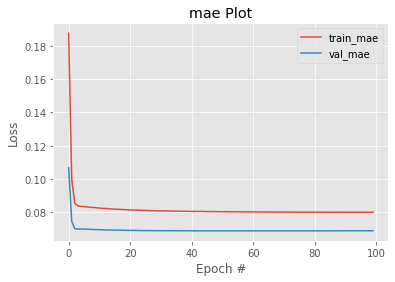

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mae"], label="train_mae")
plt.plot(np.arange(0, 100), history.history["val_mae"], label="val_mae")
plt.title("mae Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

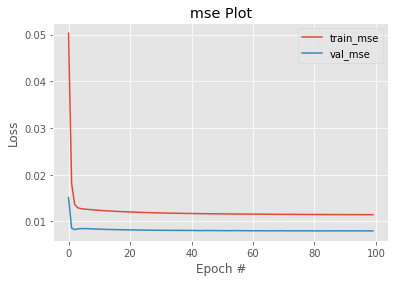

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mse"], label="train_mse")
plt.plot(np.arange(0, 100), history.history["val_mse"], label="val_mse")
plt.title("mse Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
pm10.shape

(4230, 1)

##so2

In [ ]:
# so2 = df['so2'].values
so2 = df['so2'].values.reshape(-1, 1)
so2 = min_max_scaler.fit_transform(so2)

In [ ]:
minMAE = (so2.max() - so2.min()) * 0.1
minMAE

0.1

In [ ]:
split_time = int(0.9 * len(so2))
time_train = time[:split_time]
x_train = so2[:split_time]
time_valid = time[split_time:]
x_valid = so2[split_time:]

In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(3807, 1)


In [ ]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(val_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(423, 1)


In [ ]:
model_so2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_so2.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model_so2.fit(train_set, validation_data=(val_set), epochs=100)

Epoch 1/100
473/473 [==============================] - 5s 8ms/step - loss: 0.0101 - mse: 0.0201 - mae: 0.1187 - val_loss: 0.0580 - val_mse: 0.1160 - val_mae: 0.2937
Epoch 2/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0039 - mse: 0.0077 - mae: 0.0655 - val_loss: 0.0451 - val_mse: 0.0901 - val_mae: 0.2477
Epoch 3/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0032 - mse: 0.0065 - mae: 0.0619 - val_loss: 0.0406 - val_mse: 0.0811 - val_mae: 0.2312
Epoch 4/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0031 - mse: 0.0063 - mae: 0.0614 - val_loss: 0.0386 - val_mse: 0.0771 - val_mae: 0.2238
Epoch 5/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0031 - mse: 0.0061 - mae: 0.0610 - val_loss: 0.0375 - val_mse: 0.0749 - val_mae: 0.2197
Epoch 6/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0030 - mse: 0.0060 - mae: 0.0604 - val_loss: 0.0367 - val_mse: 0.0734 - val_mae: 0.2168
Epoch 7/10

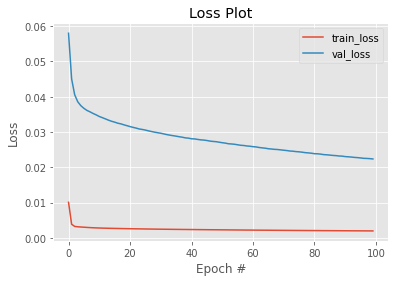

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

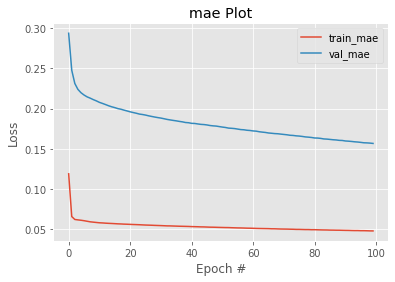

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mae"], label="train_mae")
plt.plot(np.arange(0, 100), history.history["val_mae"], label="val_mae")
plt.title("mae Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

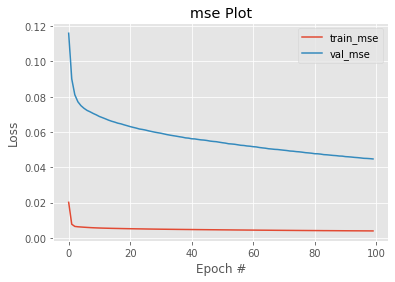

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mse"], label="train_mse")
plt.plot(np.arange(0, 100), history.history["val_mse"], label="val_mse")
plt.title("mse Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

##co

In [ ]:
# co = df['co'].values
co = df['co'].values.reshape(-1, 1)
co = min_max_scaler.fit_transform(co)

In [ ]:
minMAE = (co.max() - co.min()) * 0.1
minMAE

0.1

In [ ]:
split_time = int(0.9 * len(co))
time_train = time[:split_time]
x_train = co[:split_time]
time_valid = time[split_time:]
x_valid = co[split_time:]

In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(3807, 1)


In [ ]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(val_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(423, 1)


In [ ]:
model_co = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_co.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model_co.fit(train_set, validation_data=(val_set), epochs=100)

Epoch 1/100
473/473 [==============================] - 5s 8ms/step - loss: 0.0148 - mse: 0.0296 - mae: 0.1378 - val_loss: 0.0029 - val_mse: 0.0059 - val_mae: 0.0614
Epoch 2/100
473/473 [==============================] - 4s 8ms/step - loss: 0.0061 - mse: 0.0121 - mae: 0.0782 - val_loss: 0.0035 - val_mse: 0.0070 - val_mae: 0.0742
Epoch 3/100
473/473 [==============================] - 4s 8ms/step - loss: 0.0048 - mse: 0.0097 - mae: 0.0701 - val_loss: 0.0042 - val_mse: 0.0084 - val_mae: 0.0821
Epoch 4/100
473/473 [==============================] - 4s 8ms/step - loss: 0.0046 - mse: 0.0092 - mae: 0.0697 - val_loss: 0.0046 - val_mse: 0.0091 - val_mae: 0.0853
Epoch 5/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0046 - mse: 0.0091 - mae: 0.0699 - val_loss: 0.0046 - val_mse: 0.0093 - val_mae: 0.0859
Epoch 6/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0046 - mse: 0.0091 - mae: 0.0700 - val_loss: 0.0047 - val_mse: 0.0093 - val_mae: 0.0861
Epoch 7/10

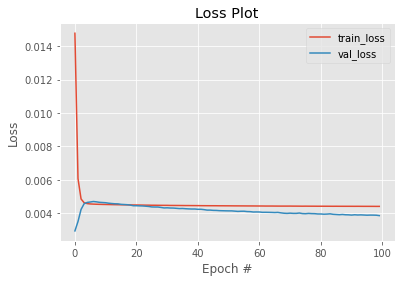

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

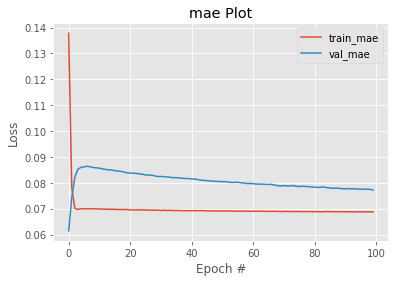

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mae"], label="train_mae")
plt.plot(np.arange(0, 100), history.history["val_mae"], label="val_mae")
plt.title("mae Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

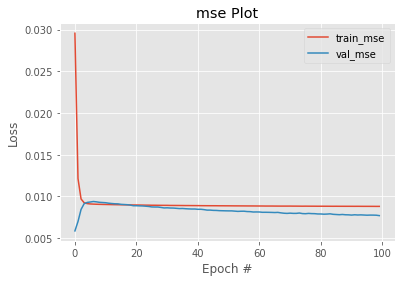

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mse"], label="train_mse")
plt.plot(np.arange(0, 100), history.history["val_mse"], label="val_mse")
plt.title("mse Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

##o3

In [ ]:
# o3 = df['o3'].values
o3 = df['o3'].values.reshape(-1, 1)
o3 = min_max_scaler.fit_transform(o3)

In [ ]:
minMAE = (o3.max() - o3.min()) * 0.1
minMAE

0.1

In [ ]:
split_time = int(0.9 * len(o3))
time_train = time[:split_time]
x_train = o3[:split_time]
time_valid = time[split_time:]
x_valid = o3[split_time:]

In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(3807, 1)


In [ ]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(val_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(423, 1)


In [ ]:
model_o3 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_o3.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model_o3.fit(train_set, validation_data=(val_set), epochs=100)

Epoch 1/100
473/473 [==============================] - 5s 8ms/step - loss: 0.0229 - mse: 0.0459 - mae: 0.1570 - val_loss: 0.0033 - val_mse: 0.0065 - val_mae: 0.0618
Epoch 2/100
473/473 [==============================] - 4s 8ms/step - loss: 0.0113 - mse: 0.0227 - mae: 0.1070 - val_loss: 0.0048 - val_mse: 0.0096 - val_mae: 0.0858
Epoch 3/100
473/473 [==============================] - 4s 8ms/step - loss: 0.0102 - mse: 0.0204 - mae: 0.1067 - val_loss: 0.0057 - val_mse: 0.0114 - val_mae: 0.0951
Epoch 4/100
473/473 [==============================] - 4s 7ms/step - loss: 0.0100 - mse: 0.0200 - mae: 0.1075 - val_loss: 0.0059 - val_mse: 0.0119 - val_mae: 0.0974
Epoch 5/100
473/473 [==============================] - 4s 8ms/step - loss: 0.0099 - mse: 0.0198 - mae: 0.1078 - val_loss: 0.0060 - val_mse: 0.0120 - val_mae: 0.0979
Epoch 6/100
473/473 [==============================] - 4s 8ms/step - loss: 0.0098 - mse: 0.0197 - mae: 0.1076 - val_loss: 0.0060 - val_mse: 0.0120 - val_mae: 0.0978
Epoch 7/10

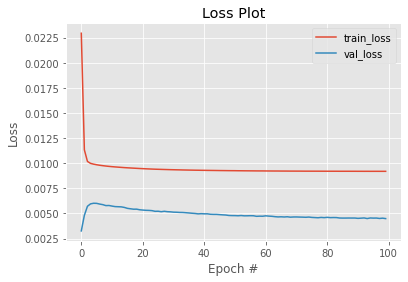

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

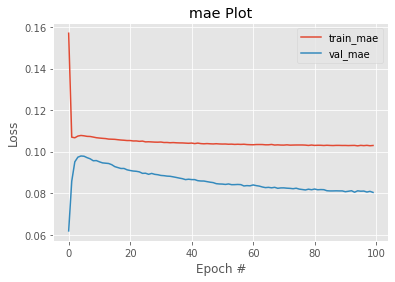

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mae"], label="train_mae")
plt.plot(np.arange(0, 100), history.history["val_mae"], label="val_mae")
plt.title("mae Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

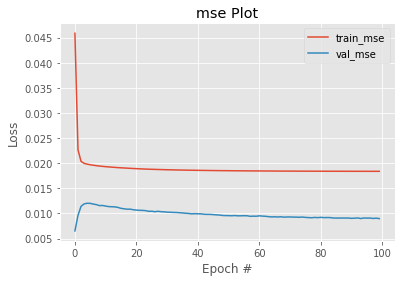

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mse"], label="train_mse")
plt.plot(np.arange(0, 100), history.history["val_mse"], label="val_mse")
plt.title("mse Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

##no2

In [ ]:
# no2 = df['no2'].values
no2 = df['no2'].values.reshape(-1, 1)
no2 = min_max_scaler.fit_transform(no2)

In [ ]:
minMAE = (no2.max() - no2.min()) * 0.1
minMAE

0.1

In [ ]:
split_time = int(0.9 * len(no2))
time_train = time[:split_time]
x_train = no2[:split_time]
time_valid = time[split_time:]
x_valid = no2[split_time:]

In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(3807, 1)


In [ ]:
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(val_set)
print(x_valid.shape)

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(423, 1)


In [ ]:
model_no2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model_no2.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history = model_no2.fit(train_set, validation_data=(val_set), epochs=100)

Epoch 1/100
473/473 [==============================] - 5s 9ms/step - loss: 0.0025 - mse: 0.0051 - mae: 0.0586 - val_loss: 0.0442 - val_mse: 0.0884 - val_mae: 0.2209
Epoch 2/100
473/473 [==============================] - 4s 8ms/step - loss: 9.2585e-04 - mse: 0.0019 - mae: 0.0332 - val_loss: 0.0398 - val_mse: 0.0796 - val_mae: 0.2035
Epoch 3/100
473/473 [==============================] - 4s 8ms/step - loss: 7.3585e-04 - mse: 0.0015 - mae: 0.0298 - val_loss: 0.0384 - val_mse: 0.0767 - val_mae: 0.1982
Epoch 4/100
473/473 [==============================] - 4s 8ms/step - loss: 7.0753e-04 - mse: 0.0014 - mae: 0.0294 - val_loss: 0.0379 - val_mse: 0.0758 - val_mae: 0.1965
Epoch 5/100
473/473 [==============================] - 4s 8ms/step - loss: 7.0134e-04 - mse: 0.0014 - mae: 0.0293 - val_loss: 0.0377 - val_mse: 0.0753 - val_mae: 0.1957
Epoch 6/100
473/473 [==============================] - 4s 8ms/step - loss: 6.9958e-04 - mse: 0.0014 - mae: 0.0293 - val_loss: 0.0375 - val_mse: 0.0751 - val_ma

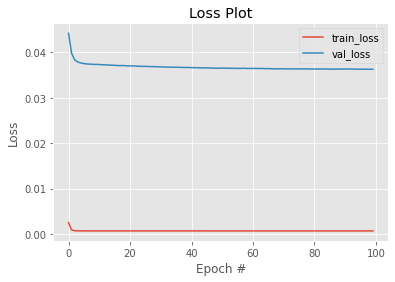

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

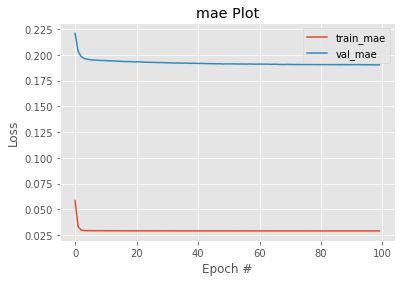

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mae"], label="train_mae")
plt.plot(np.arange(0, 100), history.history["val_mae"], label="val_mae")
plt.title("mae Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

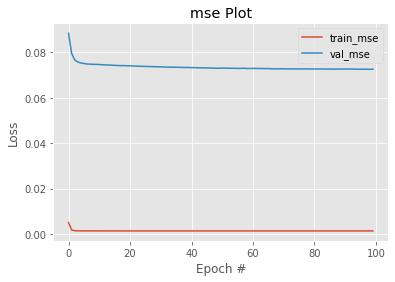

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), history.history["mse"], label="train_mse")
plt.plot(np.arange(0, 100), history.history["val_mse"], label="val_mse")
plt.title("mse Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Forecasting

In [ ]:
NUM_FORECASTS = 31 #1 bulan
SEED = 1234

##pm10

In [ ]:
output_data_pm10 = pd.DataFrame(columns = ["tanggal", "pm10"])

time = df["tanggal"].values[-1]
x_train_pm10 = df['pm10'].values
    
#Buld Model
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)
    
train_set_pm10 = windowed_dataset(x_train_pm10, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse", "mae"])
history_pm10 = model.fit(train_set_pm10, epochs=10)    

Epoch 1/10
525/525 [==============================] - 5s 7ms/step - loss: 15.4623 - mse: 462.4987 - mae: 15.9547
Epoch 2/10
525/525 [==============================] - 4s 8ms/step - loss: 14.4141 - mse: 381.0418 - mae: 14.9061
Epoch 3/10
525/525 [==============================] - 4s 7ms/step - loss: 14.3672 - mse: 378.1226 - mae: 14.8591
Epoch 4/10
525/525 [==============================] - 4s 7ms/step - loss: 14.3275 - mse: 375.9148 - mae: 14.8197
Epoch 5/10
525/525 [==============================] - 4s 7ms/step - loss: 14.3331 - mse: 375.9048 - mae: 14.8253
Epoch 6/10
525/525 [==============================] - 4s 8ms/step - loss: 14.3238 - mse: 375.5980 - mae: 14.8158
Epoch 7/10
525/525 [==============================] - 4s 7ms/step - loss: 14.2794 - mse: 373.3524 - mae: 14.7715
Epoch 8/10
525/525 [==============================] - 4s 7ms/step - loss: 14.2519 - mse: 372.7760 - mae: 14.7435
Epoch 9/10
525/525 [==============================] - 4s 8ms/step - loss: 14.2471 - mse: 372.380

In [ ]:
#Forecasting
pm10 = df['pm10'].values
data_temp = pm10.copy()
for j in range(NUM_FORECASTS):
    pm10_forecast = model_forecast(model, data_temp[-window_size:, np.newaxis], batch_size, window_size)
    pm10_forecast = pm10_forecast[:, -1, 0]
    data_temp = np.append(data_temp, pm10_forecast[0])
    time += np.timedelta64(1,'D')
    output_data_pm10 = output_data_pm10.append({"tanggal":time,
                                "pm10":pm10_forecast[0]}, 
                                ignore_index=True)

In [ ]:
output_data_pm10

,tanggal,pm10
0,2021-08-01,60.600922
1,2021-08-02,58.361027
2,2021-08-03,56.269749
3,2021-08-04,54.317223
4,2021-08-05,52.494259
5,2021-08-06,50.792248
6,2021-08-07,49.203175
7,2021-08-08,47.719540
8,2021-08-09,46.334335
9,2021-08-10,45.041046


##so2

In [ ]:
# x_train_co = df['co'].values
# x_train_o3 = df['o3'].values
# x_train_no2 = df['no2'].values

In [ ]:
output_data_so2 = pd.DataFrame(columns = ["so2"])

x_train_so2 = df['so2'].values

train_set_so2 = windowed_dataset(x_train_so2, window_size, batch_size, shuffle_buffer_size)
history_so2 = model.fit(train_set_so2, epochs=10)    

Epoch 1/10
525/525 [==============================] - 4s 7ms/step - loss: 4.8670 - mse: 84.4838 - mae: 5.3305
Epoch 2/10
525/525 [==============================] - 4s 7ms/step - loss: 4.8407 - mse: 83.7449 - mae: 5.3048
Epoch 3/10
525/525 [==============================] - 4s 7ms/step - loss: 4.8361 - mse: 83.4553 - mae: 5.2993
Epoch 4/10
525/525 [==============================] - 4s 7ms/step - loss: 4.8260 - mse: 82.9605 - mae: 5.2902
Epoch 5/10
525/525 [==============================] - 4s 7ms/step - loss: 4.8277 - mse: 83.0657 - mae: 5.2907
Epoch 6/10
525/525 [==============================] - 4s 7ms/step - loss: 4.8407 - mse: 83.1322 - mae: 5.3047
Epoch 7/10
525/525 [==============================] - 4s 7ms/step - loss: 4.8532 - mse: 83.2149 - mae: 5.3186
Epoch 8/10
525/525 [==============================] - 4s 7ms/step - loss: 4.8297 - mse: 83.1469 - mae: 5.2943
Epoch 9/10
525/525 [==============================] - 4s 7ms/step - loss: 4.8374 - mse: 82.9416 - mae: 5.3016
Epoch 10/1

In [ ]:
#Forecasting
data_temp_so2 = x_train_so2.copy()
for j in range(NUM_FORECASTS):
    so2_forecast = model_forecast(model, data_temp_so2[-window_size:, np.newaxis], batch_size, window_size)
    so2_forecast = so2_forecast[:, -1, 0]
    data_temp_so2 = np.append(data_temp_so2, so2_forecast[0])
    output_data_so2 = output_data_so2.append({"so2":so2_forecast[0]}, 
                                ignore_index=True)
output_data_so2

,so2
0,49.358723
1,48.766232
2,48.218819
3,47.713047
4,47.245762
5,46.814026
6,46.415138
7,46.046597
8,45.706093
9,45.391499


##co

In [ ]:
output_data_co = pd.DataFrame(columns = ["co"])

x_train_co = df['co'].values

train_set_co = windowed_dataset(x_train_co, window_size, batch_size, shuffle_buffer_size)
history_co = model.fit(train_set_co, epochs=10)    

Epoch 1/10
525/525 [==============================] - 4s 7ms/step - loss: 8.3259 - mse: 152.8087 - mae: 8.8119
Epoch 2/10
525/525 [==============================] - 4s 7ms/step - loss: 8.2915 - mse: 151.6393 - mae: 8.7771
Epoch 3/10
525/525 [==============================] - 4s 7ms/step - loss: 8.2603 - mse: 151.4129 - mae: 8.7460
Epoch 4/10
525/525 [==============================] - 4s 7ms/step - loss: 8.3047 - mse: 152.5468 - mae: 8.7909
Epoch 5/10
525/525 [==============================] - 4s 7ms/step - loss: 8.3094 - mse: 152.8581 - mae: 8.7953
Epoch 6/10
525/525 [==============================] - 4s 7ms/step - loss: 8.2688 - mse: 151.9094 - mae: 8.7549
Epoch 7/10
525/525 [==============================] - 4s 7ms/step - loss: 8.2544 - mse: 150.3796 - mae: 8.7402
Epoch 8/10
525/525 [==============================] - 4s 7ms/step - loss: 8.2997 - mse: 152.3086 - mae: 8.7858
Epoch 9/10
525/525 [==============================] - 4s 7ms/step - loss: 8.2728 - mse: 151.6289 - mae: 8.7587
E

In [ ]:
#Forecasting
data_temp_co = x_train_co.copy()
for j in range(NUM_FORECASTS):
    co_forecast = model_forecast(model, data_temp_co[-window_size:, np.newaxis], batch_size, window_size)
    co_forecast = co_forecast[:, -1, 0]
    data_temp_co = np.append(data_temp_co, co_forecast[0])
    output_data_co = output_data_co.append({"co":co_forecast[0]}, 
                                ignore_index=True)
output_data_co

,co
0,22.272120
1,24.210720
2,25.090414
3,25.489597
4,25.670740
5,25.752939
6,25.790241
7,25.807165
8,25.814844
9,25.818329


##o3

In [ ]:
output_data_o3 = pd.DataFrame(columns = ["o3"])

x_train_o3 = df['o3'].values

train_set_o3 = windowed_dataset(x_train_o3, window_size, batch_size, shuffle_buffer_size)
history_o3 = model.fit(train_set_o3, epochs=10)    

Epoch 1/10
525/525 [==============================] - 4s 8ms/step - loss: 30.1400 - mse: 1802.1075 - mae: 30.6356
Epoch 2/10
525/525 [==============================] - 4s 7ms/step - loss: 30.3532 - mse: 1816.0906 - mae: 30.8489
Epoch 3/10
525/525 [==============================] - 4s 7ms/step - loss: 30.2400 - mse: 1797.5748 - mae: 30.7357
Epoch 4/10
525/525 [==============================] - 4s 7ms/step - loss: 30.4080 - mse: 1821.7242 - mae: 30.9038
Epoch 5/10
525/525 [==============================] - 4s 7ms/step - loss: 30.1524 - mse: 1797.4078 - mae: 30.6480
Epoch 6/10
525/525 [==============================] - 4s 7ms/step - loss: 30.2786 - mse: 1804.9343 - mae: 30.7741
Epoch 7/10
525/525 [==============================] - 4s 7ms/step - loss: 30.2621 - mse: 1811.9850 - mae: 30.7577
Epoch 8/10
525/525 [==============================] - 4s 7ms/step - loss: 30.1168 - mse: 1782.8259 - mae: 30.6125
Epoch 9/10
525/525 [==============================] - 4s 7ms/step - loss: 30.1419 - mse:

In [ ]:
#Forecasting
data_temp_o3 = x_train_o3.copy()
for j in range(NUM_FORECASTS):
    o3_forecast = model_forecast(model, data_temp_o3[-window_size:, np.newaxis], batch_size, window_size)
    o3_forecast = o3_forecast[:, -1, 0]
    data_temp_o3 = np.append(data_temp_o3, o3_forecast[0])
    output_data_o3 = output_data_o3.append({"o3":o3_forecast[0]}, 
                                ignore_index=True)
output_data_o3

,o3
0,83.021141
1,98.388680
2,111.493362
3,122.668373
4,132.197876
5,140.324158
6,147.253845
7,153.163147
8,158.202301
9,162.499451


##no2

In [ ]:
output_data_no2 = pd.DataFrame(columns = ["no2"])

x_train_no2 = df['no2'].values

train_set_no2 = windowed_dataset(x_train_no2, window_size, batch_size, shuffle_buffer_size)
history_no2 = model.fit(train_set_no2, epochs=10)    

Epoch 1/10
525/525 [==============================] - 4s 8ms/step - loss: 5.5477 - mse: 131.0981 - mae: 6.0237
Epoch 2/10
525/525 [==============================] - 4s 7ms/step - loss: 5.5371 - mse: 130.0498 - mae: 6.0133
Epoch 3/10
525/525 [==============================] - 4s 7ms/step - loss: 5.5952 - mse: 130.3595 - mae: 6.0718
Epoch 4/10
525/525 [==============================] - 4s 7ms/step - loss: 5.5558 - mse: 130.4645 - mae: 6.0320
Epoch 5/10
525/525 [==============================] - 4s 7ms/step - loss: 5.5589 - mse: 129.6564 - mae: 6.0354
Epoch 6/10
525/525 [==============================] - 4s 7ms/step - loss: 5.5481 - mse: 129.8990 - mae: 6.0241
Epoch 7/10
525/525 [==============================] - 4s 7ms/step - loss: 5.5346 - mse: 127.7701 - mae: 6.0109
Epoch 8/10
525/525 [==============================] - 4s 7ms/step - loss: 5.5929 - mse: 128.0279 - mae: 6.0699
Epoch 9/10
525/525 [==============================] - 4s 7ms/step - loss: 5.5582 - mse: 128.4066 - mae: 6.0347
E

In [ ]:
#Forecasting
data_temp_no2 = x_train_no2.copy()
for j in range(NUM_FORECASTS):
    no2_forecast = model_forecast(model, data_temp_no2[-window_size:, np.newaxis], batch_size, window_size)
    no2_forecast = no2_forecast[:, -1, 0]
    data_temp_no2 = np.append(data_temp_so2, no2_forecast[0])
    output_data_no2 = output_data_no2.append({"no2":no2_forecast[0]}, 
                                ignore_index=True)
output_data_no2

,no2
0,22.961458
1,19.515585
2,17.561869
3,16.456810
4,15.831768
5,15.478233
6,15.278267
7,15.165163
8,15.101190
9,15.065005


In [ ]:
df_predict = pd.DataFrame()
df_predict = pd.concat([output_data_pm10, output_data_so2, output_data_co, output_data_o3, output_data_no2], axis=1)
df_predict

,tanggal,pm10,so2,co,o3,no2
0,2021-08-01,60.600922,49.358723,22.272120,83.021141,22.961458
1,2021-08-02,58.361027,48.766232,24.210720,98.388680,19.515585
2,2021-08-03,56.269749,48.218819,25.090414,111.493362,17.561869
3,2021-08-04,54.317223,47.713047,25.489597,122.668373,16.456810
4,2021-08-05,52.494259,47.245762,25.670740,132.197876,15.831768
5,2021-08-06,50.792248,46.814026,25.752939,140.324158,15.478233
6,2021-08-07,49.203175,46.415138,25.790241,147.253845,15.278267
7,2021-08-08,47.719540,46.046597,25.807165,153.163147,15.165163
8,2021-08-09,46.334335,45.706093,25.814844,158.202301,15.101190
9,2021-08-10,45.041046,45.391499,25.818329,162.499451,15.065005


# Convert data

In [ ]:
df_predict.to_csv("air_pollution_prediction.csv", index=False)